In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')
data_path = '/content/gdrive/My Drive/Uni/NLP/data/train.csv'
main_path = '/content/gdrive/My Drive/Uni/NLP/'
data = pd.read_csv(data_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Basic overview
print("Basic Overview:")
print(data.head())
print("\nNumber of reviews:", data.shape[0])

Basic Overview:
   review_id                        title    year  \
0          1  Spooky's Jump Scare Mansion  2016.0   
1          2  Spooky's Jump Scare Mansion  2016.0   
2          3  Spooky's Jump Scare Mansion  2016.0   
3          4  Spooky's Jump Scare Mansion  2015.0   
4          5  Spooky's Jump Scare Mansion  2015.0   

                                         user_review  user_suggestion  
0  I'm scared and hearing creepy voices.  So I'll...                1  
1  Best game, more better than Sam Pepper's YouTu...                1  
2  A littly iffy on the controls, but once you kn...                1  
3  Great game, fun and colorful and all that.A si...                1  
4  Not many games have the cute tag right next to...                1  

Number of reviews: 17494


In [ ]:
#Examples from the dataset
print("\nExamples of positive and negative reviews:")
print("Positive review example:", data[data['user_suggestion'] == 1].iloc[3]['user_review'])
print("Negative review example:", data[data['user_suggestion'] == 0].iloc[222]['user_review'])


Examples of positive and negative reviews:
Positive review example: Great game, fun and colorful and all that.A side note, though: When are we getting windowed mode? My computer hates fullscreen so.... yeah. The computer doesn't like to run this. Shame, because this is really enjoyable. But until then, I guess I'll settle for more Skyrim. Cheers!
Negative review example: Last played it during the Beta, now full of 12 year old kids flaming each other, waiting for hours just to find a single match.Game has changed alot since then, most are for the worse



Distribution of review lengths (words):


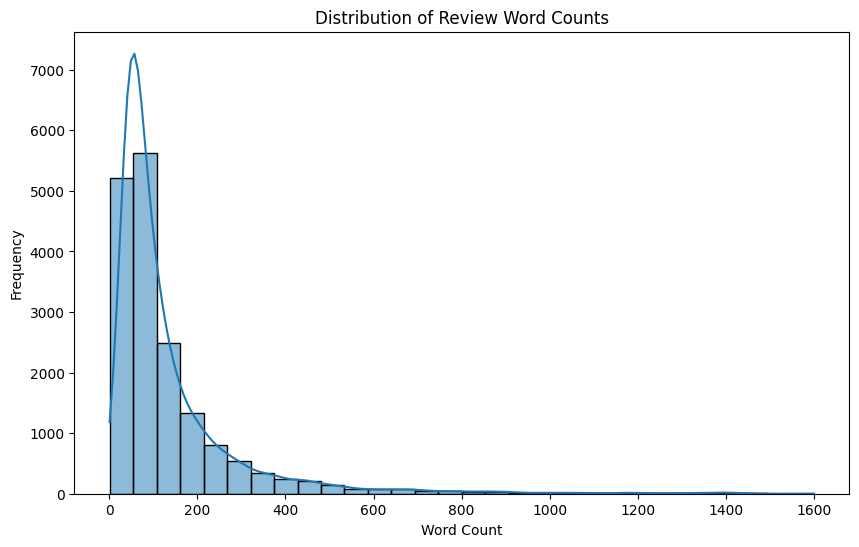

In [ ]:
#Visualizing the word count distribution
print("\nDistribution of review lengths (words):")
data['word_count'] = data['user_review'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(data['word_count'], bins=30, kde=True)
plt.title('Distribution of Review Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

In [ ]:
print("\nLabel distribution:")
print(data['user_suggestion'].value_counts(normalize=True))


Label distribution:
user_suggestion
1    0.569795
0    0.430205
Name: proportion, dtype: float64


In [6]:
import joblib
import os
model_path = os.path.join(main_path, "models/")

In [7]:
logistic_regression_model = joblib.load(os.path.join(model_path, 'logistic_regression_model.joblib'))
count_vectorizer = joblib.load(os.path.join(model_path, 'count_vectorizer.joblib'))

In [12]:
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

In [26]:
sample_data = data.sample(n=100)

test_texts = sample_data['user_review']
test_labels = sample_data['user_suggestion']

In [27]:
test_features = count_vectorizer.transform(test_texts)
lr_predictions = logistic_regression_model.predict(test_features)

In [28]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=512, return_tensors="pt")

test_encodings = {key: val.to(model.device) for key,val in test_encodings.items()}

model.eval()
with torch.no_grad():
  outputs = model(**test_encodings)
  bert_predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()

In [35]:
misclassified_lr = test_texts[(lr_predictions != test_labels)]

misclassified_bert = test_texts[(bert_predictions != test_labels)]

print("In total, the baseline model has misclassified this number of reviews:\n", len(misclassified_lr))
print("In total, the BERT model has misclassified this number of reviews:\n", len(misclassified_bert))
print("Here is an example of a misclassified review by the baseline model")
print(misclassified_lr.sample(n=1).iloc[0])
print("Here is an example of a misclassified review by the BERT model")
print(misclassified_bert.sample(n=1).iloc[0])

In total, the baseline model has misclassified this number of reviews:
 32
In total, the BERT model has misclassified this number of reviews:
 3
Here is an example of a misclassified review by the baseline model
Honestly, I really never played this all much. At first I had about maybe 30 minutes into the game. After I came back and saw what happened with new items and such, I now have 159 hrs in game. Yeah, pretty addicting game. I would say once you get the jist of the game, it's honestly the best game. Deca really saved the game after, so it all turned well with the free gifts and the bringing back of old items, mostly just making the game better in general.Ign: Pewpmaster
Here is an example of a misclassified review by the BERT model
Early Access ReviewI bought this when it was only a couple weeks old on steam. It was choppy and unoptimised, to the point where I was getting 0 FPS in combat situations. After a couple of months of neglect I came back to find the game patched several t